Description Dataset Similarity Matrix
=====================

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import csv
import multiprocessing as mp
from functools import partial
import numpy as np
from collections import Counter, defaultdict
from math import log

In [56]:
# Load files
catDescFile = 'cat_desc.csv'
catDescHeaders = None
catDescCnt = Counter()
with open(catDescFile) as fin:
    r = csv.reader(fin)
    for row in r:
        if catDescHeaders is None:
            catDescHeaders = row
            print catDescHeaders
        else:
            catDescCnt[int(row[0]), row[1]] += int(row[-1])

catNameFile = 'categoryKey.csv'
catName = {}
with open(catNameFile) as fin:
    r = csv.reader(fin)
    for row in r:
        catName[int(row[0])] = row[1]

['category_id', 'description', 'count']


In [3]:
# Intermediate information
catList = set()
descList = set()
catOccur = Counter()
for (c, d), v in catDescCnt.iteritems():
    catList.add(c)
    descList.add(d)
    catOccur[c] += v
catList = sorted(catList)
descList = sorted(descList)

def mp_kernel(descList, catDescCnt, catOccur, c):
    tmp = []
    for i, d in enumerate(descList):
        if catDescCnt[c, d] > 0:
            tmp.append((i, float(catDescCnt[c, d]) / catOccur[c]))
    return tuple(tmp)

mpPool = mp.Pool()
catDescDist = tuple(mpPool.map(partial(mp_kernel, descList, catDescCnt, catOccur), catList))

In [4]:
# Computing similarity matrix with parallelization
def sparseVec2Itr(lst1, lst2):
        i1 = i2 = 0
        while i1 < len(lst1) or i2 < len(lst2):
            if i1 == len(lst1):
                yield (0, lst2[i2][1])
                i2 += 1
            elif i2 == len(lst2):
                yield (lst1[i1][1], 0)
                i1 += 1
            elif lst1[i1][0] < lst2[i2][0]:
                yield (lst1[i1][1], 0)
                i1 += 1
            elif lst1[i1][0] > lst2[i2][0]:
                yield (0, lst2[i2][1])
                i2 += 1
            else:
                yield (lst1[i1][1], lst2[i2][1])
                i1 += 1
                i2 += 1

def mp_kernel(catDescDist, metricFn, (cat1, cat2)):
        return metricFn(sparseVec2Itr(catDescDist[cat1], catDescDist[cat2]))

def simMtx_mp(catDescDist, metricFn, halfMatrix=False):
    numCat = len(catDescDist)
    entries = None
    if halfMatrix:
        entries = [(x, y) for x in xrange(numCat) for y in xrange(x+1)]
    else:
        entries = [(x, y) for x in xrange(numCat) for y in xrange(numCat)]

    mpPool = mp.Pool()
    ans = mpPool.map(partial(mp_kernel, catDescDist, metricFn), entries)
    mpPool.close()

    simMtx = np.zeros((numCat, numCat))
    for (x, y), v in zip(entries, ans):
        simMtx[x, y] = v
    if halfMatrix:
        for x in xrange(numCat):
            for y in xrange(x+1, numCat):
                simMtx[x, y] = simMtx[y, x]
    return simMtx

In [11]:
from random import random
def checkMetricFnSym(metricFn, size=1000, threshold=1e-9):
    s1 = []
    s2 = []
    for i in xrange(size):
        if random() * 3 < 1:
            s1.append(0)
            s2.append(random())
        elif random() * 2 < 1:
            s1.append(random())
            s2.append(0)
        else:
            s1.append(random())
            s2.append(random())
    s1 = [float(x) / sum(s1) for x in s1]
    s2 = [float(x) / sum(s2) for x in s2]
    ans1 = metricFn(zip(s1, s2))
    ans2 = metricFn(zip(s2, s1))
    print abs(ans1 - ans2),
    if abs(ans1 - ans2) < threshold:
        print 'ok'
    else:
        print 'ERROR'

In [60]:
def stat_simMtx(mtx, printNum=10):
    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(1,1,1)
    simMap = ax.pcolormesh(mtx)
    ax.autoscale(tight=True)
    ax.set_frame_on(False)
    ax.axis('off')
    cbar = fig.colorbar(simMap, ax=ax)
    plt.show()

    values = np.concatenate(mtx)
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    n, bins, patches = ax.hist(values, 50)
    ax.set_yscale('log')
    plt.show()
    
    entries = []
    for x in xrange(len(catName)):
        for y in xrange(x):
            entries.append((x, y, mtx[x, y]))
    entries.sort(key=lambda x: x[2])
    
    print 'Smallest pairs:'
    for x, y, v in entries[:printNum]:
        print catName[catList[x]], '&' , catName[catList[y]], '-->', v
    print

    print 'Biggest pairs:'
    for x, y, v in entries[-printNum:]:
        print catName[catList[x]], '&' , catName[catList[y]], '-->', v

In [12]:
def JensenShannonDiv(itr):
    ans = 0.0
    for x, y in itr:
        if x + y == 0: continue
        m = (x + y) * 0.5
        if x > 0:
            ans += 0.5 * x * log(x / m)
        if y > 0:
            ans += 0.5 * y * log(y / m)
    return ans
checkMetricFnSym(JensenShannonDiv)

0.0 ok


In [13]:
jsdSimMtx1 = simMtx_mp(catDescDist, JensenShannonDiv, halfMatrix=True)

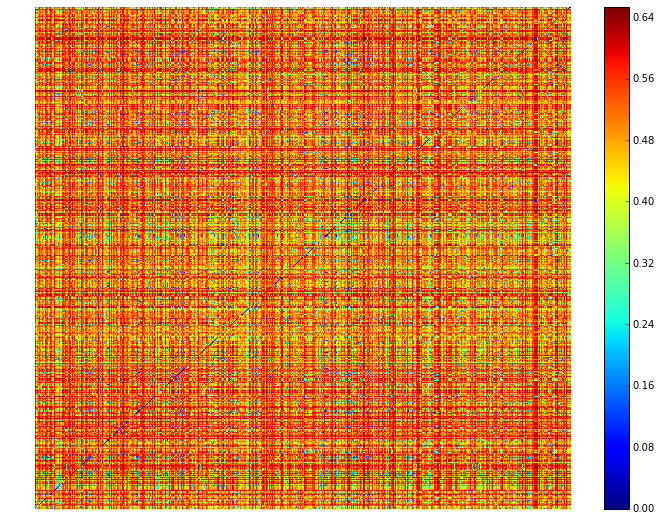

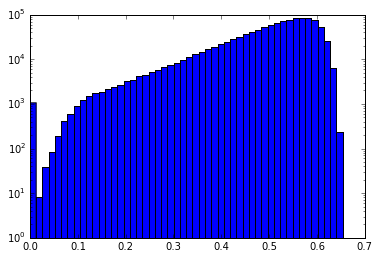

Smallest pairs:
motel room & hotel room --> 0.0223322494639
waterfall (cataract) & cataract --> 0.0225815658049
suvic & guest room --> 0.0253361763504
waterfall (cascade) & cascade --> 0.0254002028128
waterfall (cataract) & waterfall --> 0.0299291111572
waterfall (cascade) & waterfall --> 0.0309745578149
underwater ocean deep & ocean deep --> 0.031507702981
waterfall & cascade --> 0.0328314711791
suvic & master bedroom --> 0.0334239584099
free standing & carport (freestanding) --> 0.033429157066

Biggest pairs:
waterfall (cataract) & bookstore --> 0.646631077956
wave & ball pit --> 0.646736762473
wave & motel room --> 0.646816961717
wave & hotel room --> 0.646967385412
wave & boxing ring --> 0.647025566494
wave & banquet hall --> 0.647384201402
wave & arena (hockey) --> 0.648945081642
wave & batters box --> 0.650234495555
wave & badminton court --> 0.652716686585
wave & stadium --> 0.653589039889


In [61]:
stat_simMtx(jsdSimMtx1)